In [2]:
import numpy as np
import matplotlib.pyplot as plt
import networkx as nx

Remember that in week 1 we had generated open-loop commands for a set of manoeuvres such as
$[("straight", 5), ("right", 90), ("straight", 6), ("left", 90)]$

Let us do repeat, but with a change. Instead of left/ right, simply use turn and a signed angle.
$[("straight", 5), ("turn", -90), ("straight", 6), ("turn", 90)]$

You can use cubic_spiral() from previous notebook

In [20]:
num_pts = 100
num_st_pts = 10
v = 1

def cubic_spiral(theta_i, theta_f, n=10):
    x = np.linspace(0, 1, num=n)
    #-2*x**3 + 3*x**2
    return (theta_f-theta_i)*(-2*x**3 + 3*x**2) + theta_i

def straight(dist, curr_pose, n=num_st_pts):
    # the straight-line may be along x or y axis
    #curr_theta will determine the orientation
    x0,y0,t0 = curr_pose
    t = [t0]*n
    dn = dist/n
    x = x0 + np.cumsum(dn*np.cos(t))
    y = y0 + np.cumsum(dn*np.sin(t))
    return x,y,t

def turn(change, curr_pose,vel=v,dt=0.1, n=num_pts):
    # adjust scaling constant for desired turn radius
    x0,y0,t0 = curr_pose
    t = cubic_spiral(t0, t0 + np.deg2rad(change), n)
    x= x0 + np.cumsum(v*dt*np.cos(t))
    y= y0 + np.cumsum(v*dt*np.sin(t))
    return x,y,t  

def generate_trajectory(route, init_pose = (0, 0,np.pi/2)):
    curr_pose = init_pose
    func = {'straight': straight, 'turn': turn}
    x, y, t = np.array([]), np.array([]),np.array([])
    for manoeuvre, command in route:
        px, py, pt = func[manoeuvre](command,curr_pose)
        # print(py)
        curr_pose = (px[-1],py[-1],pt[-1])
        # update x, y, t using np.concatenate and px,py,pt
        x = np.concatenate([x,px])
        y = np.concatenate([y,py])
        t = np.concatenate([t,pt])
    return x, y, t

### Plot the trajectory
plot the trajectory and the change in orientation in separate plots

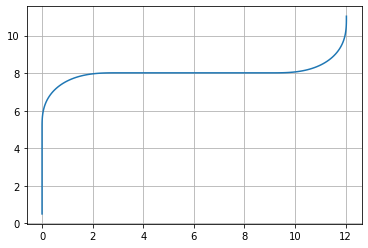

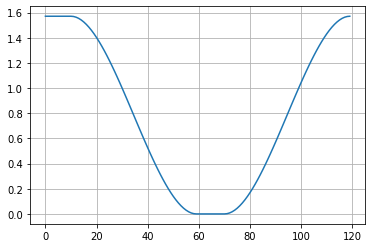

In [13]:
route = [("straight",5),("turn",-90),("straight",6),("turn",90)]
x,y,t = generate_trajectory(route)
plt.figure()
plt.plot(x,y)
plt.grid()
plt.figure()
plt.plot(t)
plt.grid()

## Convert 

A* or Djikstra gives a sequence of $\{(x_i, y_i)\}$. We need to convert it to a sequence of {"straight", "turn"} if we are use generate_trajectory()

Let us look at a simple method. Assume that the successive line segments are orthogonal (reasonable in the grid world). If we find the corner point, we can demarcate. 

For 3 consecutive points $(x_1,y_1), (x_2, y_2), (x_3, y_3)$ if 
$(x_1 - x_2)(y_3-y2) - (x_3-x_2)(y_2-y_1) \neq 0$, then $(x_2, y_2)$ is a corner point

Think about what is happening if

1. $(x_1 - x_2)(y_3-y2) - (x_3-x_2)(y_2-y_1) > 0$

2. $(x_1 - x_2)(y_3-y2) - (x_3-x_2)(y_2-y_1) < 0$

In [7]:
def euclidean(node1, node2):
    x1,y1 = node1
    x2,y2 = node2
    dist = np.sqrt(pow((y2-y1),2) + pow((x2-x1),2))
    return dist

[['straight', 4.0], ['turn', -90], ['straight', 4.0]]


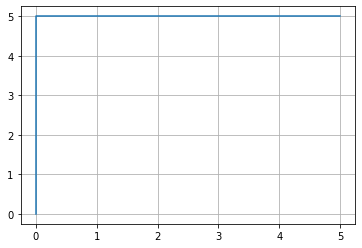

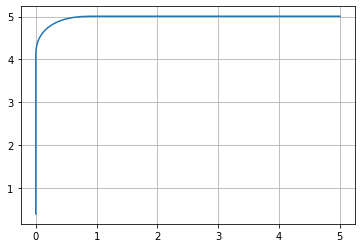

In [21]:
# here is a code to generate 2 orthogonal 
# line segments of lengths 6
from functools import reduce

s1, s2 = 6, 6
y1 = list(range(s1))
x1 = [0]*s1

x2 = list(range(s2))
y2 = [y1[-1]]*s2

x, y = x1[:-1]+x2, y1[:-1]+y2
plt.figure()
plt.plot(x, y)
plt.grid()

def make_route(coords):
  #find the corner point and plot it
  corners = []
  x,y = zip(*coords)
  for x1,x2,x3, y1,y2,y3 in zip(x[:-2],x[1:-1],x[2:],y[:-2],y[1:-1],y[2:]):
    slope = (x2-x1)*(y3-y2) - (x3-x2)*(y2-y1)
    if np.abs(slope) > 0.0:
      if slope > 0:
        corners.append([x2, y2,90])
      else:
        corners.append([x2, y2,-90])
  # Fix a turn radius r
  adj_coords = corners[1:]
  org_coords = corners[:-1]
  dists = [euclidean(n1[:-1],n2[:-1]) for n1,n2 in zip(org_coords,adj_coords)]
  if dists:
    smallest_dist = reduce(lambda a,b : a if a < b else b,dists)
    r = smallest_dist/2
  else:
    r = 1
  first_flag = 1
  # Shorten the straight segments by r
  # convert this into {("straight", s1), ("turn", +/- 90), ("straight", s2)}
  route = []
  for i in range(len(corners)):
    if first_flag == 1:
      first_flag = 0
      dist = euclidean(corners[i][:-1],(x[0],y[0])) - r
    else:
      dist = dists[i-1] - 2*r
    if dist > 0:
      route.append(['straight',dist])
    route.append(['turn',corners[i][-1]])
  dist = euclidean(corners[-1][:-1],(x[-1],y[-1])) - r
  route.append(['straight',dist])
  return route,corners,r

coords = list(map(lambda i,j: (i,j),x,y))
route,corners,r = make_route(coords)
print(route)
# use generate_trajectory() and plot the smooth path
v = r/6
dt = 0.1
num_pts = 100
rx,ry,t = generate_trajectory(route)
plt.figure()
plt.plot(rx,ry)
plt.grid()

# More complex example
Borrow the Grid world code from week 2 notebook. Get the A* path and smoothen it using the routine from above

[[0, 2, -90], [6, 2, 90], [6, 5, -90], [14, 5, -90], [14, 1, 90], [18, 1, 90], [18, 3, 90], [17, 3, -90], [17, 14, 90], [13, 14, 90], [13, 10, -90], [10, 10, -90], [10, 14, 90], [9, 14, -90], [9, 16, 90], [7, 16, -90], [7, 18, 90], [0, 18, -90]]
[(0, 0), (0, 1), (0, 2), (1, 2), (2, 2), (3, 2), (4, 2), (5, 2), (6, 2), (6, 3), (6, 4), (6, 5), (7, 5), (8, 5), (9, 5), (10, 5), (11, 5), (12, 5), (13, 5), (14, 5), (14, 4), (14, 3), (14, 2), (14, 1), (15, 1), (16, 1), (17, 1), (18, 1), (18, 2), (18, 3), (17, 3), (17, 4), (17, 5), (17, 6), (17, 7), (17, 8), (17, 9), (17, 10), (17, 11), (17, 12), (17, 13), (17, 14), (16, 14), (15, 14), (14, 14), (13, 14), (13, 13), (13, 12), (13, 11), (13, 10), (12, 10), (11, 10), (10, 10), (10, 11), (10, 12), (10, 13), (10, 14), (9, 14), (9, 15), (9, 16), (8, 16), (7, 16), (7, 17), (7, 18), (6, 18), (5, 18), (4, 18), (3, 18), (2, 18), (1, 18), (0, 18), (0, 19)]
[['straight', 1.5], ['turn', -90], ['straight', 5.0], ['turn', 90], ['straight', 2.0], ['turn', -90]

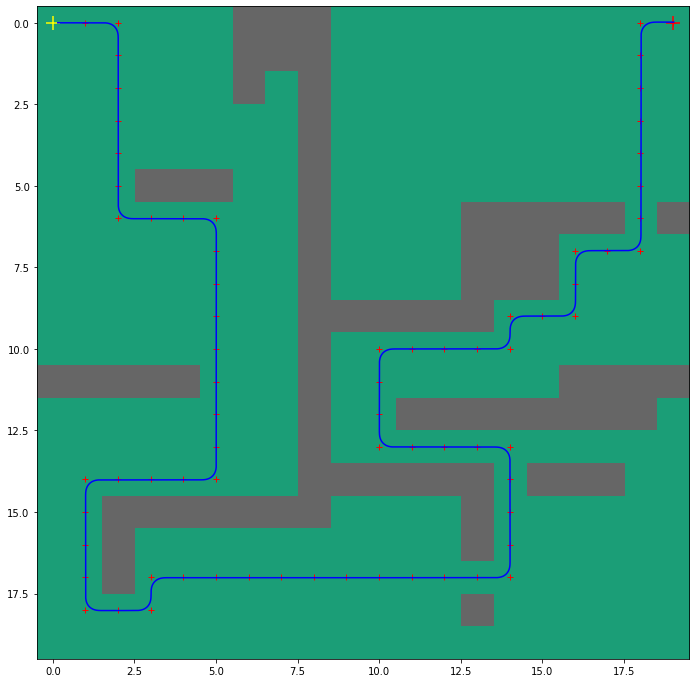

In [22]:
grid = np.load("astar_grid.npy")
# you can define your own start/ end
start = (0, 0)
goal = (0, 19)
grid_size = grid.shape
G = nx.grid_2d_graph(*grid_size)

for i in range(grid_size[0]):
  for j in range(grid_size[1]):
    if grid[i,j] == 1:
      G.remove_node((i,j))
nx.set_edge_attributes(G,1,'cost')
astar_path = nx.astar_path(G,start,goal,heuristic=euclidean,weight='cost')
route,corners,r = make_route(astar_path)
print(corners)
print(astar_path)
print(route)
v = r/6
dt = 0.1
num_pts = 100
rx,ry,t = generate_trajectory(route)

# visualize the start/ end and the robot's environment
fig, ax = plt.subplots(figsize=(12,12))
ax.imshow(grid, cmap=plt.cm.Dark2)
ax.scatter(start[1],start[0], marker = "+", color = "yellow", s = 200)
ax.scatter(goal[1],goal[0], marker = "+", color = "red", s = 200)
for s in astar_path[1:]:
  ax.plot(s[1], s[0],'r+')
ax.plot(ry,rx,'blue')
plt.show()

In [24]:
# This data is needed for Stanley tracker notebook
data_x = np.asarray(rx)
data_y = np.asarray(ry)
np.save('smooth_route_astar_grid_x.npy',data_x)
np.save('smooth_route_astar_grid_y.npy',data_y)

This approach of path planning with 90 deg turns juxtaposed between straight segments works well in structured environments.

In the general case, where $A^*$/ $RRT^*$ path is a sequence of piecewise linear segments, we will perform a path optimization routine directly. 

There are 3 more advanced manouevres that you may need

1. Lane-change: Robot has to move laterally but without change to the orientation

2. Inplace: Robot has to turn around itself
    
3. Reverse: Straights or turns in reverse

Lane-change has to be applied as a combination of 2 cubic spirals (90 to 0 and 0 to 90). Inplace and Reverse are situational constructs